# NNARS

In [10]:
import math
import numpy as np

## Input

f: function to estimate, with support in [0,1]^d.  
n: budget available in terms of evaluations of f.  
cf: non-vanishing bound. Since n has to be taken large enough to ensure cf > 1/(log log n), we take cf of this order.  
H: from Holder, of the order log n.  
s: from Holder.  
d: dimension.  
M_init: constant upper bound on f.  

Every parameter is a constant, except for f.
f is a python function: array (size, d) -> array (size) 

## Output

X_N

In [11]:
# Finds the nearest neighbor of point
def get_NN(point, neighbors):
    """
    :param point: we are looking for its nearest neighbor
    :param neighbors: potential nearest neighbors
    :return: index of the nearest neighbor, distance to the nearest neighbor
    """
    distances = np.linalg.norm(point - neighbors, ord=np.inf, axis=1)
    indexNN = np.argmin(distances, axis = 0)
    return (indexNN, distances[indexNN])

In [12]:
# Estimate f_chi according to definition 3.1
def estimate_f_chi(X_N, fX_N):
    """
    :param X_N: points which have been evaluated
    :param fX_N: their evaluations by f
    :return: estimation of f for each cell, positions of the center of each cell, distances from center of each cell to
             the nearest evaluated point
    """
    #Step 1: build a grid with cells of side-length 1/N**(1/d)
    lenChi = fX_N.size
    d = X_N.shape[1]
    centerCells = np.arange(1, 2. * (int(lenChi ** (1. / d)) + 1)) / (2. * (int(lenChi ** (1. / d)) + 1))
    centerCells = np.vstack(map(np.ravel,
                                np.meshgrid(*[centerCells for _ in range(d)])
                                )
                            ).T

    #Step 2: f_chi is constant on each cell, equal to the nearest neighbour estimator from the center of the cell.
    indicesNN = []
    distancesNN = []

    for centerCell in centerCells:
        indexNN, distanceNN = get_NN(centerCell, X_N)
        indicesNN.append(indexNN)
        distancesNN.append(distanceNN)
    fCells = fX_N[indicesNN]
    return fCells, centerCells, distancesNN



In [13]:
def compute_gM(fCells, H, distancesNN, s, d):
    """
    :param fCells: estimation of f for each cell.
    :param distancesNN: distances from center of each cell to the nearest evaluated point
    :return: values of g in each cell
    """
    #Compute every value of g as in equations (4),(5)
    lenChi = fCells.shape[0]
    r_hat = H * (np.asarray(distancesNN) + 1. / (2 * (int(lenChi ** (1 / d)) + 1)))**s
    gCells = (fCells + np.max(r_hat)) # a less conservative version would correspond to not taking the max.
                                      # This would lead to better results in cases when the hypotheses are satisfied.
    return gCells


def sample_from_g(gCells, centerCells, size):
    """
    :param gCells: values of g in each cell
    :param centerCells: positions of the center of each cell. (numberCells,dimension)
    :param size: number of points to be sampled
    :return: sampled points, their evaluations by g
    """
    d = centerCells.shape[1]
    wCells = gCells / gCells.sum()  # "* 1/(lenChi + 1)**d * 1/M" useless because renormalize
    indices = np.random.choice(len(wCells), size=size, p=wCells)
    X = np.random.uniform(-1., 1., size=(size, d)) * centerCells[0, 0]
    X += centerCells[indices]
    gX = gCells[indices]
    return np.asarray(X), np.array(gX)


def RSS(f,gCells, centerCells, size):
    """
    :param f: function to sample from
    :param gCells: values of g in each cell
    :param centerCells: positions of the center of each cell. (numberCells,dimension)
    :param size: number of points to be sampled from g, i.e. budget at this step
    :return: points sampled from g, their evaluations by f, the accepted indices, the number of times f/g>1
    """
    X, gX = sample_from_g(gCells, centerCells, size=size)
    U = np.random.uniform(0,1,size=size)
    fX = np.squeeze(f(X))
    ratioX = fX/gX #no M because we did not renormalize
    isAccepted = ratioX >= U
    return X, fX, np.arange(isAccepted.size)[isAccepted], (ratioX > 1).sum()

In [30]:
def NNARS(f, n, d, cf, H, s, M_init=1.):
    """
    :param f: function to sample from
    :param n: budget
    :param d: dimension
    :param cf: constant
    :param H: constant
    :param s: constant
    :param M_init: upper bound on f
    :return: points sampled from f
    """
    N = int(np.log(n))
    N_k = N

    fX_N = np.asarray([])

    indicesAccepted = []

    p = int(math.ceil(3. / (2. * cf)))
    K = int(math.ceil(np.log(float(n) / N + 1.) / np.log(p)))

    gCells = M_init * np.ones(1)
    centerCells = np.ones((1, d)) / 2.

    countTotal = 0
    untrusted = 0
    for k in range(1, K + 1):
        X_N_out, fX_N_out, indicesAccepted_out, untrusted_out = RSS(f, gCells, centerCells, size=N_k)
        indicesAccepted = np.append(indicesAccepted, indicesAccepted_out + fX_N.size)
        untrusted += untrusted_out
        if indicesAccepted.shape[0] == 0:
            print("rate of untrusted: ", 0)
        else:
            print("rate of untrusted: ", float(untrusted) / indicesAccepted.shape[0])
        X_N = np.vstack((X_N, X_N_out)) if fX_N.size > 0 else X_N_out
        fX_N = np.append(fX_N, fX_N_out)
        fCells, centerCells, distancesNN = estimate_f_chi(X_N, fX_N)
        gCells = compute_gM(fCells, H, distancesNN, s, d)
        countTotal += N_k
        if k < K-1:
            N_k = p * N_k
        else:
            N_k = n - countTotal #int(N * (1 - p ** (K-1)) / (1. - p))
    indicesAccepted = indicesAccepted.astype(int)
    return X_N[indicesAccepted]

## Example

In [38]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.integrate import quad

### Target density

In [51]:
class Sin(object):

    def __init__(self, beta):
        self.beta = beta
        self.zstore = None

    def dimensions(self):
        return 1

    def negative_energy(self, sample):
        return self.beta * np.sin(2*np.pi*sample)

    def state_space(self):
        return (0, 1)

    def log_density(self, sample):
        return self.negative_energy(sample) - np.log(self.z())

    def z(self):
        if self.zstore is not None:
            return self.zstore
        else:
            left, right = self.state_space()
            self.zstore, err = quad(lambda x: float(np.exp(self.negative_energy(x))), left, right)
            return self.zstore
        
# Parameters
d = 1
target = Sin(1)
budget = 10**5
M_init = 2.5
cf = 0.25  
H = 2. * np.pi * np.e/1.2 
s = 1.
##########################

f= lambda t: np.exp(target.log_density(t))

In [105]:
samples = NNARS(f, budget, 1, cf, H, s, M_init=M_init)

('rate of untrusted: ', 0.0)
('rate of untrusted: ', 0.0)
('rate of untrusted: ', 0.0)
('rate of untrusted: ', 0.0)
('rate of untrusted: ', 0.0)
('rate of untrusted: ', 0.0)


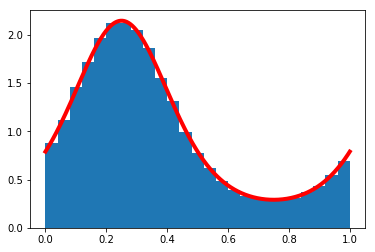

In [106]:
plt.hist(samples, bins=25, normed=True)
x = np.linspace(0, 1, 1000)
y = f(x)
plt.plot(x, y, "r", linewidth=4)
plt.show()